In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from os.path import isfile, join
from sys import getsizeof
import glob
from random import *
import time
from pickle import dump
import joblib
import keras as k
from keras import utils, models, layers, optimizers
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.layers import Dense, GRU, BatchNormalization, Activation, LSTM, Flatten
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/DMSP_particle_precipitation/Dataset/AI_Ready_DMSP_Data.csv')

In [4]:
df.head()

,Datetimes,SC_AACGM_LAT,SC_AACGM_LTIME,ELE_TOTAL_ENERGY_FLUX,ELE_TOTAL_ENERGY_FLUX_STD,ELE_AVG_ENERGY,ELE_AVG_ENERGY_STD,ID_SC,sin_ut,cos_ut,...,AE_5min,AL_5min,AU_5min,SymH_5min,PC_5min,vsw_5min,vx_5min,psw_5min,borovsky_5min,newell_5min
0,1987-01-12 12:57:00,51.143220,5.664024,2.057827e+08,0.411230,39.89341,0.411485,6.0,-0.246153,-0.969231,...,86.0,-61.0,25.0,3.0,0.77,356.0,-355.5,2.96,17439.640589,2489.686963
1,1987-01-12 12:58:00,54.137207,5.535848,2.509837e+08,0.478268,40.82392,0.478568,6.0,-0.250380,-0.968148,...,86.0,-61.0,25.0,3.0,0.77,356.0,-355.5,2.96,17439.640589,2489.686963
2,1987-01-12 13:01:00,62.928176,5.031172,4.469146e+08,0.603362,143.77360,0.604023,6.0,-0.263031,-0.964787,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015
3,1987-01-12 13:02:00,65.719631,4.794780,1.934849e+10,0.103648,820.36560,0.103671,6.0,-0.267238,-0.963630,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015
4,1987-01-12 13:03:00,68.392364,4.507448,3.913337e+11,0.114959,5291.57100,0.114959,6.0,-0.271440,-0.962455,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015


In [5]:
df.shape

(1945887, 154)

In [6]:
df_cumulative = df.copy()

In [7]:
df_cumulative = df_cumulative.set_index('Datetimes')
df_cumulative.index = pd.to_datetime(df_cumulative.index)

In [8]:
df_cumulative.columns.to_list()

['SC_AACGM_LAT',
 'SC_AACGM_LTIME',
 'ELE_TOTAL_ENERGY_FLUX',
 'ELE_TOTAL_ENERGY_FLUX_STD',
 'ELE_AVG_ENERGY',
 'ELE_AVG_ENERGY_STD',
 'ID_SC',
 'sin_ut',
 'cos_ut',
 'sin_doy',
 'cos_doy',
 'sin_SC_AACGM_LTIME',
 'cos_SC_AACGM_LTIME',
 'F107',
 'Bz',
 'By',
 'Bx',
 'AE',
 'AL',
 'AU',
 'SymH',
 'PC',
 'vsw',
 'vx',
 'psw',
 'borovsky',
 'newell',
 'F107_6hr',
 'Bz_6hr',
 'By_6hr',
 'Bx_6hr',
 'AE_6hr',
 'AL_6hr',
 'AU_6hr',
 'SymH_6hr',
 'PC_6hr',
 'vsw_6hr',
 'vx_6hr',
 'psw_6hr',
 'borovsky_6hr',
 'newell_6hr',
 'F107_5hr',
 'Bz_5hr',
 'By_5hr',
 'Bx_5hr',
 'AE_5hr',
 'AL_5hr',
 'AU_5hr',
 'SymH_5hr',
 'PC_5hr',
 'vsw_5hr',
 'vx_5hr',
 'psw_5hr',
 'borovsky_5hr',
 'newell_5hr',
 'F107_3hr',
 'Bz_3hr',
 'By_3hr',
 'Bx_3hr',
 'AE_3hr',
 'AL_3hr',
 'AU_3hr',
 'SymH_3hr',
 'PC_3hr',
 'vsw_3hr',
 'vx_3hr',
 'psw_3hr',
 'borovsky_3hr',
 'newell_3hr',
 'F107_1hr',
 'Bz_1hr',
 'By_1hr',
 'Bx_1hr',
 'AE_1hr',
 'AL_1hr',
 'AU_1hr',
 'SymH_1hr',
 'PC_1hr',
 'vsw_1hr',
 'vx_1hr',
 'psw_1hr',
 '

In [9]:
cols_to_drop = [c for c in df_cumulative.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('_5min'in c) | ('15min' in c)| ('5hr' in c) | ('F107_' in c) | ('vx' in c) | ('AE' in c) | ('newell' in c) | ('borovsky' in c) | ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]
df_cumulative = df_cumulative.drop(columns=cols_to_drop)

In [10]:
df_cumulative.columns.to_list()

['SC_AACGM_LAT',
 'ELE_TOTAL_ENERGY_FLUX',
 'ID_SC',
 'sin_ut',
 'cos_ut',
 'sin_doy',
 'cos_doy',
 'sin_SC_AACGM_LTIME',
 'cos_SC_AACGM_LTIME',
 'F107',
 'Bz',
 'By',
 'Bx',
 'AL',
 'AU',
 'SymH',
 'PC',
 'vsw',
 'psw',
 'Bz_6hr',
 'By_6hr',
 'Bx_6hr',
 'AL_6hr',
 'AU_6hr',
 'SymH_6hr',
 'PC_6hr',
 'vsw_6hr',
 'psw_6hr',
 'Bz_3hr',
 'By_3hr',
 'Bx_3hr',
 'AL_3hr',
 'AU_3hr',
 'SymH_3hr',
 'PC_3hr',
 'vsw_3hr',
 'psw_3hr',
 'Bz_1hr',
 'By_1hr',
 'Bx_1hr',
 'AL_1hr',
 'AU_1hr',
 'SymH_1hr',
 'PC_1hr',
 'vsw_1hr',
 'psw_1hr',
 'Bz_45min',
 'By_45min',
 'Bx_45min',
 'AL_45min',
 'AU_45min',
 'SymH_45min',
 'PC_45min',
 'vsw_45min',
 'psw_45min',
 'Bz_30min',
 'By_30min',
 'Bx_30min',
 'AL_30min',
 'AU_30min',
 'SymH_30min',
 'PC_30min',
 'vsw_30min',
 'psw_30min',
 'Bz_10min',
 'By_10min',
 'Bx_10min',
 'AL_10min',
 'AU_10min',
 'SymH_10min',
 'PC_10min',
 'vsw_10min',
 'psw_10min']

In [11]:
print('number of input features total = {}'.format(df_cumulative.shape[1]))

number of input features total = 73


In [12]:
eflux_threshold_quantile = 99.995
eflux_threshold = .99995
erg_eV_factor = (1.60218e-12)

In [13]:
print(df_cumulative.shape)
threshold_drop_val = np.percentile(df_cumulative['ELE_TOTAL_ENERGY_FLUX'],eflux_threshold_quantile)
print('... dropping rows where total electron energy flux is greater than {:.4E} [eV/cm2/s/ster]'.format(threshold_drop_val))
print('--------> number dropped = {}'.format(len( np.argwhere(df_cumulative['ELE_TOTAL_ENERGY_FLUX'].values > threshold_drop_val) )))
df_cumulative = df_cumulative[ (df_cumulative['ELE_TOTAL_ENERGY_FLUX'].values < threshold_drop_val) ]
print(df_cumulative.shape)

(1945887, 73)
... dropping rows where total electron energy flux is greater than 7.3673E+13 [eV/cm2/s/ster]
--------> number dropped = 98
(1945789, 73)


In [14]:
df_cumulative.describe()

,SC_AACGM_LAT,ELE_TOTAL_ENERGY_FLUX,ID_SC,sin_ut,cos_ut,sin_doy,cos_doy,sin_SC_AACGM_LTIME,cos_SC_AACGM_LTIME,F107,...,psw_30min,Bz_10min,By_10min,Bx_10min,AL_10min,AU_10min,SymH_10min,PC_10min,vsw_10min,psw_10min
count,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,...,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06
mean,6.570635e+01,4.370772e+10,1.525736e+01,-1.545410e-02,-5.742040e-04,-5.886700e-02,1.281526e-02,3.735496e-02,-9.759640e-02,1.179359e+02,...,1.709994e+00,7.497813e-01,2.959074e-02,5.672489e-02,-6.812476e+01,4.882927e+01,-7.594912e+00,5.696859e-01,4.147391e+02,1.712483e+00
std,1.113037e+01,2.891010e+11,1.859397e+00,7.043815e-01,7.096535e-01,6.857191e-01,7.253690e-01,8.130553e-01,5.727313e-01,4.578386e+01,...,1.126584e+00,2.840595e+00,3.764705e+00,3.355476e+00,8.294130e+01,4.456893e+01,1.241943e+01,9.313294e-01,8.640116e+01,1.133739e+00
min,4.500001e+01,2.632692e+06,6.000000e+00,-1.000000e+00,-1.000000e+00,-9.999907e-01,-9.999630e-01,-1.000000e+00,-1.000000e+00,6.510000e+01,...,1.000000e-02,-9.150000e+00,-2.399000e+01,-1.769000e+01,-1.001000e+03,-3.500000e+01,-1.350000e+02,-8.120000e+00,2.097000e+02,2.000000e-02
25%,5.639839e+01,1.694962e+08,1.300000e+01,-7.163019e-01,-7.132504e-01,-7.176769e-01,-7.324941e-01,-8.898352e-01,-5.708443e-01,8.480000e+01,...,1.030000e+00,-1.080000e+00,-2.620000e+00,-2.500000e+00,-9.000000e+01,1.800000e+01,-1.400000e+01,1.000000e-02,3.515000e+02,1.030000e+00
50%,6.683312e+01,5.540831e+08,1.500000e+01,-3.053851e-02,-1.836970e-16,-1.116590e-01,2.151610e-02,2.416185e-01,-1.467515e-01,1.072000e+02,...,1.440000e+00,5.100000e-01,4.000000e-02,6.000000e-02,-3.300000e+01,3.400000e+01,-7.000000e+00,4.200000e-01,4.003000e+02,1.440000e+00
75%,7.455945e+01,1.303514e+10,1.700000e+01,6.883546e-01,7.132504e-01,6.152846e-01,7.498264e-01,8.730348e-01,3.497406e-01,1.392000e+02,...,2.070000e+00,2.260000e+00,2.680000e+00,2.590000e+00,-1.600000e+01,6.500000e+01,0.000000e+00,1.060000e+00,4.596000e+02,2.070000e+00
max,8.998340e+01,7.137946e+13,1.800000e+01,1.000000e+00,1.000000e+00,9.999907e-01,1.000000e+00,1.000000e+00,1.000000e+00,9.999000e+02,...,4.700000e+01,5.547000e+01,2.691000e+01,3.731000e+01,3.200000e+01,4.800000e+02,8.200000e+01,1.837000e+01,9.033000e+02,4.576000e+01


In [15]:
mask_val = [(df_cumulative.index.year == 2002) & (df_cumulative['ID_SC'].values==13)]

In [16]:
df_val = df_cumulative[mask_val[0]].copy(deep=True)
df_val.head()

,SC_AACGM_LAT,ELE_TOTAL_ENERGY_FLUX,ID_SC,sin_ut,cos_ut,sin_doy,cos_doy,sin_SC_AACGM_LTIME,cos_SC_AACGM_LTIME,F107,...,psw_30min,Bz_10min,By_10min,Bx_10min,AL_10min,AU_10min,SymH_10min,PC_10min,vsw_10min,psw_10min
Datetimes,,,,,,,,,,,,,,,,,,,,,
2002-01-01 13:00:00,87.102285,3.254178e+09,13.0,-0.258819,-0.965926,0.017213,0.999852,-0.824183,-0.566324,224.5,...,1.29,-0.87,1.58,6.58,-45.0,75.0,-26.0,1.13,426.1,1.38
2002-01-01 13:01:00,84.240306,2.043148e+08,13.0,-0.263031,-0.964787,0.017213,0.999852,-0.974897,-0.222658,224.5,...,1.29,-0.87,1.58,6.58,-45.0,75.0,-26.0,1.13,426.1,1.38
2002-01-01 13:02:00,81.120657,1.193426e+11,13.0,-0.267238,-0.963630,0.017213,0.999852,-0.994684,-0.102976,224.5,...,1.29,-0.87,1.58,6.58,-45.0,75.0,-26.0,1.13,426.1,1.38
2002-01-01 13:03:00,77.943089,2.837295e+10,13.0,-0.271440,-0.962455,0.017213,0.999852,-0.999060,-0.043348,224.5,...,1.29,-0.87,1.58,6.58,-45.0,75.0,-26.0,1.13,426.1,1.38
2002-01-01 13:04:00,74.739148,6.009746e+10,13.0,-0.275637,-0.961262,0.017213,0.999852,-0.999981,-0.006218,224.5,...,1.29,-0.87,1.58,6.58,-45.0,75.0,-26.0,1.13,426.1,1.38


In [17]:
df_train = df_cumulative.copy(deep=True).drop( df_cumulative.index[mask_val[0]])
df_train.head()

,SC_AACGM_LAT,ELE_TOTAL_ENERGY_FLUX,ID_SC,sin_ut,cos_ut,sin_doy,cos_doy,sin_SC_AACGM_LTIME,cos_SC_AACGM_LTIME,F107,...,psw_30min,Bz_10min,By_10min,Bx_10min,AL_10min,AU_10min,SymH_10min,PC_10min,vsw_10min,psw_10min
Datetimes,,,,,,,,,,,,,,,,,,,,,
1987-01-12 12:57:00,51.143220,2.057827e+08,6.0,-0.246153,-0.969231,0.205104,0.97874,0.996134,0.087845,68.9,...,3.61,1.25,6.52,-3.03,-36.0,19.0,4.0,0.71,364.4,3.09
1987-01-12 12:58:00,54.137207,2.509837e+08,6.0,-0.250380,-0.968148,0.205104,0.97874,0.992626,0.121216,68.9,...,3.61,1.25,6.52,-3.03,-36.0,19.0,4.0,0.71,364.4,3.09
1987-01-12 13:01:00,62.928176,4.469146e+08,6.0,-0.263031,-0.964787,0.205104,0.97874,0.968006,0.250928,68.9,...,3.66,1.51,6.42,-2.72,-61.0,25.0,3.0,0.77,356.0,2.96
1987-01-12 13:02:00,65.719631,1.934849e+10,6.0,-0.267238,-0.963630,0.205104,0.97874,0.950633,0.310316,68.9,...,3.66,1.51,6.42,-2.72,-61.0,25.0,3.0,0.77,356.0,2.96
1987-01-12 13:03:00,68.392364,3.913337e+11,6.0,-0.271440,-0.962455,0.205104,0.97874,0.924624,0.380881,68.9,...,3.66,1.51,6.42,-2.72,-61.0,25.0,3.0,0.77,356.0,2.96


In [18]:
df_val.dropna(inplace=True)

In [19]:
print('validation data shape = {}'.format(df_val.shape))
print('train data shape = {}'.format(df_train.shape))

validation data shape = (96993, 73)
train data shape = (1823384, 73)


In [20]:
from sklearn.preprocessing import StandardScaler
feature_cols = [c for c in df_cumulative.columns if not 'ELE' in c]
X_val = df_val[feature_cols].copy(deep=True)
y_val = df_val['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train[feature_cols].copy(deep=True)
y_train = df_train['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = StandardScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

In [21]:
X_train_scaled

array([[-1.31268696, -5.11249892, -0.32920135, ...,  0.14873472,
        -0.56662997,  1.24912738],
       [-1.04348662, -5.11249892, -0.33520324, ...,  0.14873472,
        -0.56662997,  1.24912738],
       [-0.25305846, -5.11249892, -0.35316784, ...,  0.21381172,
        -0.66368159,  1.13299112],
       ...,
       [-1.21132321,  1.41753636, -0.39483107, ..., -0.82742022,
         1.32472131,  0.24856879],
       [-1.44971992,  1.41753636, -0.38890198, ..., -0.82742022,
         1.32472131,  0.24856879],
       [-1.68801987,  1.41753636, -0.38296511, ..., -0.82742022,
         1.32472131,  0.24856879]])

In [22]:
y_train = y_train * np.pi
y_val = y_val * np.pi
y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)
y_train[y_train == 0] = 0.00001
y_val[y_val == 0] = 0.00001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))

In [23]:
X_train_scaled.shape

(1823384, 72)

In [24]:
from keras import backend as K
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [25]:
import keras
model1 = Sequential()
model1.add(Dense(128, input_shape=(X_train_scaled.shape[1:]), kernel_initializer='uniform', activation = keras.layers.LeakyReLU(alpha=0.01)))
model1.add(Dense(64, kernel_initializer='uniform', activation=keras.layers.LeakyReLU(alpha=0.01)))
model1.add(Dense(32, kernel_initializer='uniform', activation=keras.layers.LeakyReLU(alpha=0.01)))
model1.add(Dense(1, kernel_initializer='uniform',activation='linear'))
opt = Adam()
model1.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])


In [26]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               9344      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 19,713
Trainable params: 19,713
Non-trainable params: 0
_________________________________________________________________


In [27]:
curr_dt_time = datetime.datetime.now()
model_name = 'DMSP1'+'_'+str(curr_dt_time).replace(' ','').replace(':','_')+'/'
if not os.path.exists(model_name):
  os.mkdir(model_name)
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
callbacks_list = [checkpoint, early_stopping]

In [28]:
history = model1.fit(X_train_scaled,y_train_log, validation_data=(X_val_scaled, y_val_log), epochs=50, batch_size=64, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/50
28488/28491 [============================>.] - ETA: 0s - loss: 1.5275 - root_mean_squared_error: 1.2359 - r2_score: -0.2490
Epoch 1: val_loss improved from inf to 0.89908, saving model to DMSP1_2022-10-2514_33_04.054823/model-00001-1.52745-1.23590-0.89908-0.94820.h5
28491/28491 [==============================] - 93s 3ms/step - loss: 1.5275 - root_mean_squared_error: 1.2359 - r2_score: -0.2489 - val_loss: 0.8991 - val_root_mean_squared_error: 0.9482 - val_r2_score: 0.0920
Epoch 2/50
28476/28491 [============================>.] - ETA: 0s - loss: 0.5098 - root_mean_squared_error: 0.7140 - r2_score: 0.6009
Epoch 2: val_loss improved from 0.89908 to 0.42660, saving model to DMSP1_2022-10-2514_33_04.054823/model-00002-0.50976-0.71398-0.42660-0.65314.h5
28491/28491 [==============================] - 93s 3ms/step - loss: 0.5098 - root_mean_squared_error: 0.7140 - r2_score: 0.6009 - val_loss: 0.4266 - val_root_mean_squared_error: 0.6531 - val_r2_score: 0.5897
Epoch 3/50
28481/28491 [

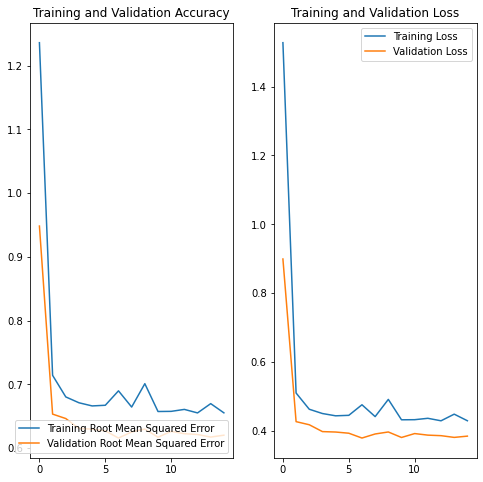

In [30]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(15)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
model2 = Sequential()
model2.add(Dense(128, input_shape=(X_train_scaled.shape[1:]), kernel_initializer='uniform', activation=keras.layers.LeakyReLU(alpha=0.01)))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(64, kernel_initializer='uniform', activation=keras.layers.LeakyReLU(alpha=0.01)))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(32, kernel_initializer='uniform', activation=keras.layers.LeakyReLU(alpha=0.01)))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(1, kernel_initializer='uniform',activation='linear'))
opt = Adam() 
model2.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])

In [33]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               9344      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 64)               

In [34]:
curr_dt_time = datetime.datetime.now()
model_name = 'DMSP2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
  os.mkdir(model_name)
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
callbacks_list = [checkpoint, early_stopping]

In [35]:
history = model2.fit(X_train_scaled,y_train_log, validation_data=(X_val_scaled, y_val_log), epochs=100, batch_size=64, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/100
28485/28491 [============================>.] - ETA: 0s - loss: 2.6857 - root_mean_squared_error: 1.6388 - r2_score: -1.3290
Epoch 1: val_loss improved from inf to 0.68559, saving model to DMSP2_2022-10-2515_03_56.239541/model-00001-2.68533-1.63870-0.68559-0.82800.h5
28491/28491 [==============================] - 147s 5ms/step - loss: 2.6853 - root_mean_squared_error: 1.6387 - r2_score: -1.3286 - val_loss: 0.6856 - val_root_mean_squared_error: 0.8280 - val_r2_score: 0.3554
Epoch 2/100
28482/28491 [============================>.] - ETA: 0s - loss: 0.6877 - root_mean_squared_error: 0.8293 - r2_score: 0.4645
Epoch 2: val_loss improved from 0.68559 to 0.46742, saving model to DMSP2_2022-10-2515_03_56.239541/model-00002-0.68765-0.82925-0.46742-0.68368.h5
28491/28491 [==============================] - 152s 5ms/step - loss: 0.6876 - root_mean_squared_error: 0.8292 - r2_score: 0.4645 - val_loss: 0.4674 - val_root_mean_squared_error: 0.6837 - val_r2_score: 0.5562
Epoch 3/100
28484/28

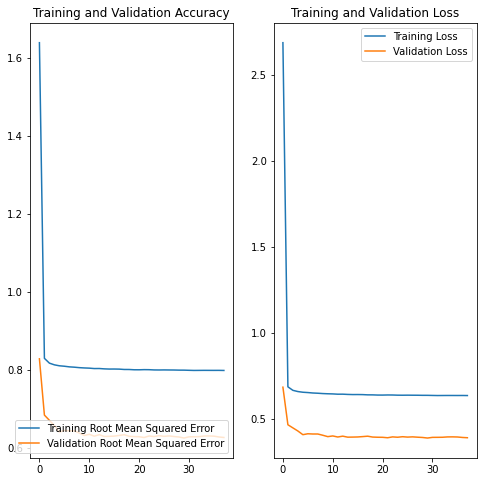

In [36]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(38)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()